In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline    
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

Data Cleaning and Model Building

In [3]:
df = pd.read_csv('Dataset_Fertiliser_Final.csv')
df.dropna(inplace=True)
df=df.drop(columns=['Region'])
print(df.head())

              State      City    N   P    K   Soil_Type  Crop_Type   Moisture  \
0        Tamil Nadu   Madurai  138  77   64    Red Soil  Groundnut  12.160828   
1          Nagaland     Wokha  145  61  117  Silty Soil      Maize  12.257557   
2  Himachal Pradesh    Shimla   72  73  115  Loamy Soil      Wheat  21.896327   
3      Chhattisgarh    Raipur   54  98  107    Red Soil     Pulses  26.793276   
4           Mizoram  Champhai   63  45   46  Silty Soil      Maize  10.636263   

    Humidity  Temperature        pH  Fertilizer_Amount  \
0  87.668261    33.329422  5.203292         120.509284   
1  86.301543    26.562098  5.459615         181.186432   
2  71.856662    22.855753  5.301568         174.023582   
3  65.977762    37.712986  4.702356         198.535738   
4  49.252353    20.561778  6.398202         189.394417   

  Fertilizer_Recommendation  
0                  10-26-26  
1                  17-17-17  
2                  10-26-26  
3                  10-26-26  
4             

In [4]:
df.columns

Index(['State', 'City', 'N', 'P', 'K', 'Soil_Type', 'Crop_Type', 'Moisture',
       'Humidity', 'Temperature', 'pH', 'Fertilizer_Amount',
       'Fertilizer_Recommendation'],
      dtype='object')

In [5]:
df.dtypes

State                         object
City                          object
N                              int64
P                              int64
K                              int64
Soil_Type                     object
Crop_Type                     object
Moisture                     float64
Humidity                     float64
Temperature                  float64
pH                           float64
Fertilizer_Amount            float64
Fertilizer_Recommendation     object
dtype: object

In [6]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}':")
    print(unique_values)
    print("\n")

Unique values in 'State':
['Tamil Nadu' 'Nagaland' 'Himachal Pradesh' 'Chhattisgarh' 'Mizoram'
 'Haryana' 'Maharashtra' 'Manipur' 'Goa' 'Uttar Pradesh' 'Rajasthan'
 'West Bengal' 'Assam' 'Karnataka' 'Punjab' 'Andhra Pradesh' 'Telangana'
 'Madhya Pradesh' 'Meghalaya' 'Bihar' 'Uttarakhand' 'Kerala' 'Odisha'
 'Arunachal Pradesh' 'Gujarat' 'Tripura' 'Jharkhand' 'Sikkim']


Unique values in 'City':
['Madurai' 'Wokha' 'Shimla' 'Raipur' 'Champhai' 'Faridabad' 'Mumbai'
 'Thoubal' 'Vasco da Gama' 'Agra' 'Jodhpur' 'Durgapur' 'Dibrugarh'
 'Nagpur' 'Kanpur' 'Gurgaon' 'Bengaluru' 'Chandigarh' 'Visakhapatnam'
 'Warangal' 'Lucknow' 'Bhopal' 'Hyderabad' 'Shillong' 'Patna' 'Chennai'
 'Haridwar' 'Bilaspur' 'Amritsar' 'Kozhikode' 'Karimnagar' 'Bhubaneswar'
 'Gaya' 'Dehradun' 'Itanagar' 'Ahmedabad' 'Rourkela' 'Dharmanagar'
 'Churachandpur' 'Bhagalpur' 'Tawang' 'Durg' 'Kochi' 'Jamshedpur'
 'Kolkata' 'Cuttack' 'Coimbatore' 'Udaipur' 'Aizawl' 'Jowai' 'Dimapur'
 'Mysuru' 'Surat' 'Dhanbad' 'Pune' 'Jalandhar' '

In [7]:
X=df[['State','City','N','P','K','Soil_Type','Crop_Type','Moisture','Humidity','Temperature','pH']]
y=df[['Fertilizer_Amount','Fertilizer_Recommendation']]

In [8]:
le = LabelEncoder()
df['Fertilizer_Recommendation'] = le.fit_transform(df['Fertilizer_Recommendation'])

In [10]:
numerical_features = ['N', 'P', 'K', 'Moisture', 'Humidity', 'Temperature', 'pH']
categorical_features = ['State', 'City', 'Soil_Type', 'Crop_Type']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_amt = y_train['Fertilizer_Amount']
y_train_rec = y_train['Fertilizer_Recommendation']
y_test_amt = y_test['Fertilizer_Amount']
y_test_rec = y_test['Fertilizer_Recommendation']

le = LabelEncoder()
combined_rec = pd.concat([y_train_rec, y_test_rec])
le.fit(combined_rec)

y_train_rec_encoded = le.transform(y_train_rec)
y_test_rec_encoded = le.transform(y_test_rec)

pipeline_amt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50,max_depth=10,min_samples_leaf=4,min_samples_split=10,random_state=40))
])

pipeline_rec = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=10))
])

pipeline_amt.fit(X_train, y_train_amt)
pipeline_rec.fit(X_train, y_train_rec_encoded)

y_pred_amt = pipeline_amt.predict(X_test)
y_pred_rec = pipeline_rec.predict(X_test)

y_pred_rec_decoded = le.inverse_transform(y_pred_rec.astype(int))

mse_amt = mean_squared_error(y_test_amt, y_pred_amt)
r2_amt = r2_score(y_test_amt, y_pred_amt)
mse_rec = mean_squared_error(y_test_rec_encoded, y_pred_rec)
r2_rec = r2_score(y_test_rec_encoded, y_pred_rec)

input_data = {
    'State': ['West Bengal'],
    'City': ['Durgapur'],
    'N': [62],
    'P': [59],
    'K': [45],
    'Soil_Type': ['Loamy Soil'],
    'Crop_Type': ['Wheat'],
    'Moisture': [20.0],
    'Humidity': [40.0],
    'Temperature': [30.0],
    'pH': [6.5]
}

input_df = pd.DataFrame(input_data)
predicted_amt = pipeline_amt.predict(input_df)
predicted_rec_encoded = pipeline_rec.predict(input_df)
predicted_rec = le.inverse_transform(predicted_rec_encoded.astype(int))

print("Predicted Fertilizer Amount:", round(predicted_amt[0],2))
print("Predicted Fertilizer Recommendation:", predicted_rec[0])


Predicted Fertilizer Amount: 129.32
Predicted Fertilizer Recommendation: 28-28


HyperParameter Tuning

In [89]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline_amt, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train_amt)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_amt_best = best_model.predict(X_test)
mse_amt_best = mean_squared_error(y_test_amt, y_pred_amt_best)
r2_amt_best = r2_score(y_test_amt, y_pred_amt_best)

print("Optimized Amount Model MSE:", mse_amt_best)
print("Optimized Amount Model R^2:", r2_amt_best)

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
Optimized Amount Model MSE: 2072.2608002022857
Optimized Amount Model R^2: 0.022110958115090118


In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

param_dist = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30, 40],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],  # Correct value for None
    'regressor__bootstrap': [True, False],
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

pipeline_rec = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0))
])

random_search = RandomizedSearchCV(
    estimator=pipeline_rec,
    param_distributions=param_dist,
    n_iter=50,  
    cv=5,  
    scoring='r2',  
    n_jobs=-1,  
    verbose=1,  
    random_state=0  
)
random_search.fit(X_train, y_train_rec_encoded)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_pipeline_rec = random_search.best_estimator_
y_pred_rec = best_pipeline_rec.predict(X_test)

mse_rec = mean_squared_error(y_test_rec_encoded, y_pred_rec)
r2_rec = r2_score(y_test_rec_encoded, y_pred_rec)

print("Recommendation Model MSE:", mse_rec)
print("Recommendation Model R^2:", r2_rec)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': None, 'regressor__max_depth': 20, 'regressor__criterion': 'squared_error', 'regressor__bootstrap': True}
Best Score: 0.9940663072691871
Recommendation Model MSE: 0.014305771378968256
Recommendation Model R^2: 0.9882044037260621


In [98]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

param_dist_amt = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30, 40],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],  # Correct value for None
    'regressor__bootstrap': [True, False],
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

pipeline_amt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0))
])

random_search_amt = RandomizedSearchCV(
    estimator=pipeline_amt,
    param_distributions=param_dist_amt,
    n_iter=50, 
    cv=5,  
    scoring='r2', 
    n_jobs=-1, 
    verbose=1,  
    random_state=0  
)

random_search_amt.fit(X_train, y_train_amt)

print("Best Parameters for Amount Model:", random_search_amt.best_params_)
print("Best Score for Amount Model:", random_search_amt.best_score_)

best_pipeline_amt = random_search_amt.best_estimator_
y_pred_amt = best_pipeline_amt.predict(X_test)

mse_amt = mean_squared_error(y_test_amt, y_pred_amt)
r2_amt = r2_score(y_test_amt, y_pred_amt)

print("Amount Model MSE:", mse_amt)
print("Amount Model R^2:", r2_amt)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Amount Model: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'log2', 'regressor__max_depth': 10, 'regressor__criterion': 'friedman_mse', 'regressor__bootstrap': True}
Best Score for Amount Model: -0.03386068767588557
Amount Model MSE: 2111.2020705410823
Amount Model R^2: 0.0037347761510874156


Plotting parts:

In [107]:
model = pipeline_amt.named_steps['regressor']

if not hasattr(model, 'feature_importances_'):
    raise AttributeError("The model does not have 'feature_importances_' attribute. Ensure the model is fitted and supports feature importances.")

importances = model.feature_importances_

preprocessor = pipeline.named_steps['preprocessor']

categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out()
feature_names = np.concatenate([categorical_features, numeric_features])

sorted_indices = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Feature importances for the model:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

Feature importances for the model:
State_Bihar: 0.1222
State_Chhattisgarh: 0.1211
State_Gujarat: 0.1108
State_Goa: 0.1048
State_Assam: 0.1025
State_Andhra Pradesh: 0.0865
State_Arunachal Pradesh: 0.0816
pH: 0.0134
P: 0.0106
Crop_Type_Vegetables: 0.0076
Crop_Type_Pulses: 0.0073
City_Bengaluru: 0.0066
Crop_Type_Jute: 0.0066
Crop_Type_Coffee: 0.0065
Crop_Type_Cashew: 0.0062
City_Raipur: 0.0053
City_Aizawl: 0.0051
N: 0.0050
City_Vadodara: 0.0044
State_West Bengal: 0.0043
Crop_Type_Soybean: 0.0041
City_Kozhikode: 0.0040
Crop_Type_Maize: 0.0040
City_Dimapur: 0.0039
City_Manali: 0.0038
Temperature: 0.0038
City_Ahmedabad: 0.0035
State_Mizoram: 0.0034
City_Shimla: 0.0034
State_Karnataka: 0.0034
City_Jodhpur: 0.0032
City_Coimbatore: 0.0032
City_Kolkata: 0.0032
State_Tamil Nadu: 0.0031
City_Jowai: 0.0031
State_Punjab: 0.0030
Moisture: 0.0030
Soil_Type_Alluvial Soil: 0.0030
City_Tawang: 0.0028
State_Haryana: 0.0027
City_Jalandhar: 0.0026
City_Thoubal: 0.0025
City_Kanpur: 0.0025
K: 0.0025
Crop_Type

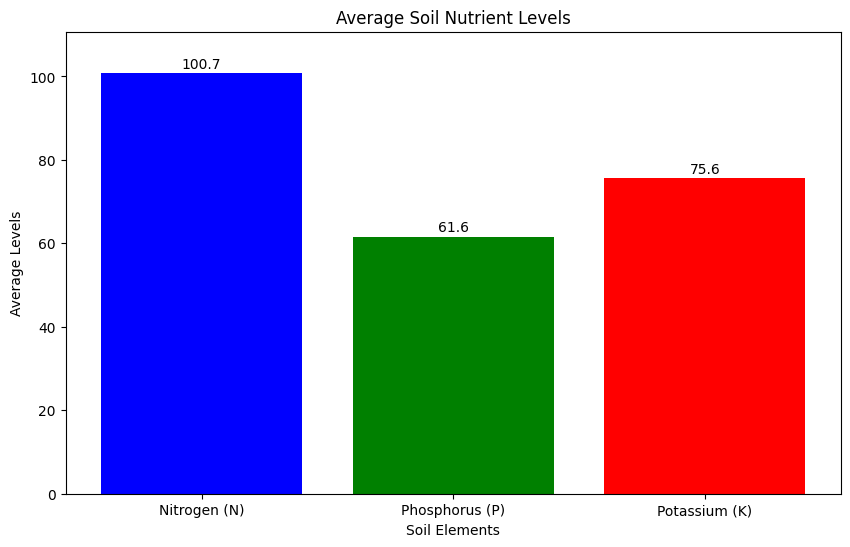

In [108]:
mean_n = df['N'].mean()
mean_p = df['P'].mean()
mean_k = df['K'].mean()

soil_elements = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']
levels = [mean_n, mean_p, mean_k]

plt.figure(figsize=(10, 6))
bars = plt.bar(soil_elements, levels, color=['blue', 'green', 'red'])

plt.xlabel('Soil Elements')
plt.ylabel('Average Levels')
plt.title('Average Soil Nutrient Levels')
plt.ylim(0, max(levels) + 10)  # Adding some space above the highest bar

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom')

plt.show()

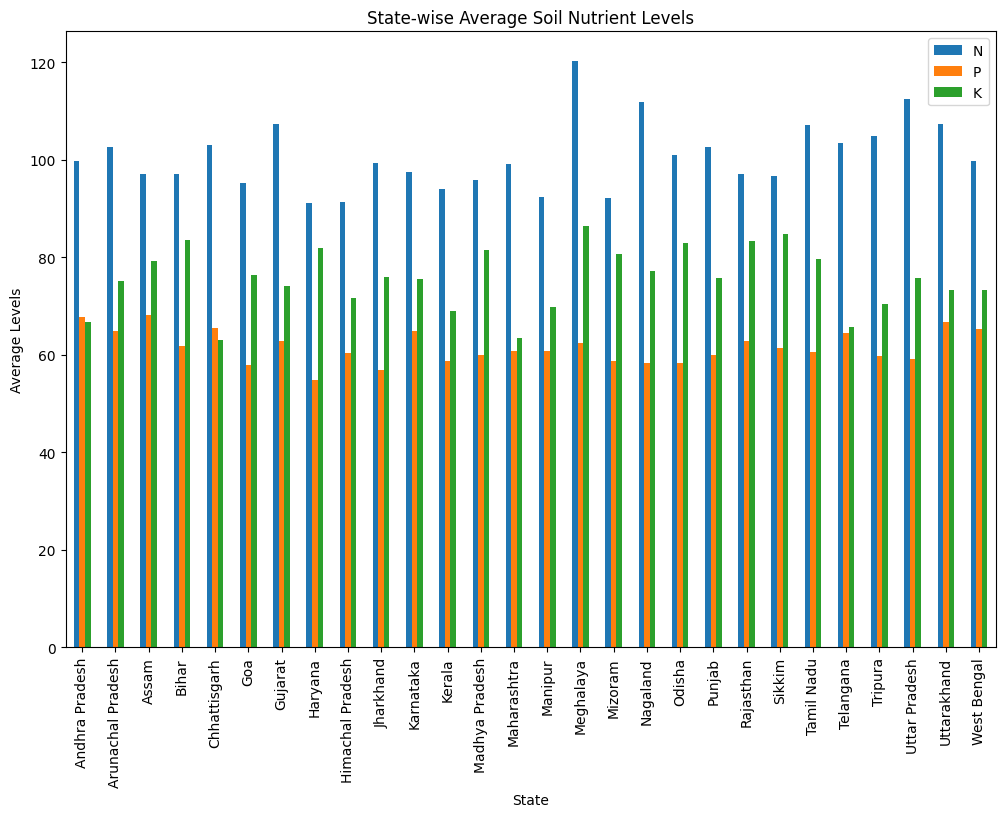

In [109]:
statewise_mean = df.groupby('State')[['N', 'P', 'K']].mean()

statewise_mean.plot(kind='bar', figsize=(12, 8))

plt.xlabel('State')
plt.ylabel('Average Levels')
plt.title('State-wise Average Soil Nutrient Levels')

plt.show()

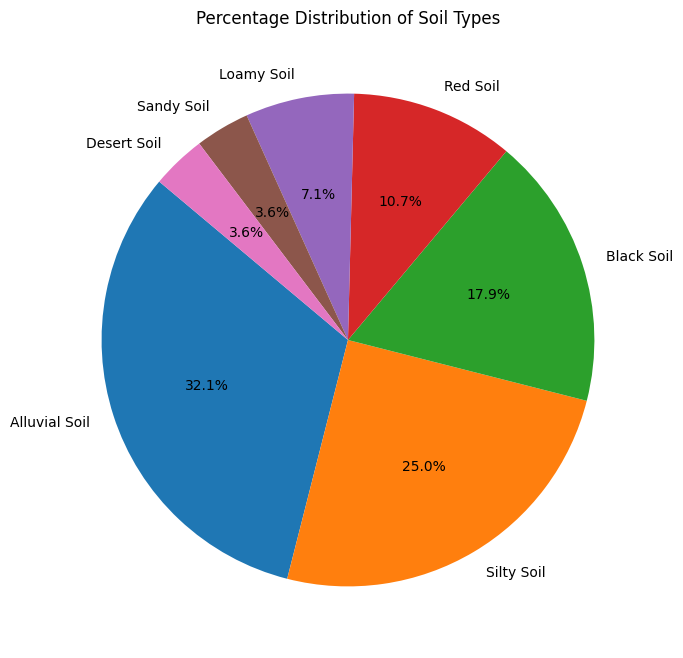

In [110]:
soil_type_counts = df['Soil_Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(soil_type_counts, labels=soil_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Soil Types')

plt.show()

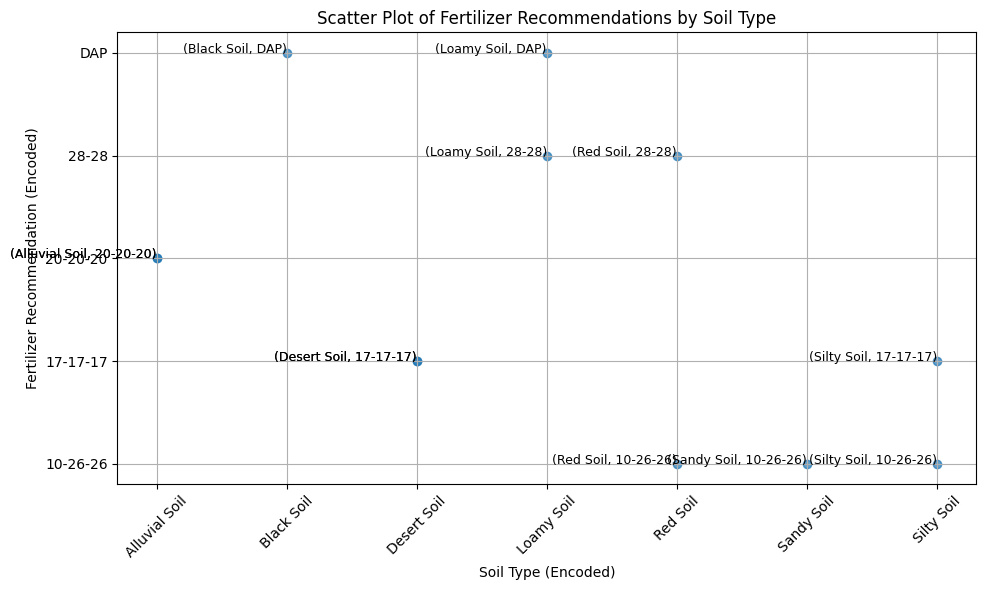

In [122]:
soil_encoder = LabelEncoder()
fertilizer_encoder = LabelEncoder()

df['Soil_Type_Encoded'] = soil_encoder.fit_transform(df['Soil_Type'])
df['Fertilizer_Recommendation_Encoded'] = fertilizer_encoder.fit_transform(df['Fertilizer_Recommendation'])

plt.figure(figsize=(10, 6))
plt.scatter(df['Soil_Type_Encoded'], df['Fertilizer_Recommendation_Encoded'], alpha=0.7)

for i in range(len(df)):
    plt.text(df['Soil_Type_Encoded'].iloc[i], df['Fertilizer_Recommendation_Encoded'].iloc[i],
             f'({df["Soil_Type"].iloc[i]}, {df["Fertilizer_Recommendation"].iloc[i]})',
             fontsize=9, ha='right')

plt.title('Scatter Plot of Fertilizer Recommendations by Soil Type')
plt.xlabel('Soil Type (Encoded)')
plt.ylabel('Fertilizer Recommendation (Encoded)')
plt.xticks(ticks=soil_encoder.transform(soil_encoder.classes_), labels=soil_encoder.classes_, rotation=45)
plt.yticks(ticks=fertilizer_encoder.transform(fertilizer_encoder.classes_), labels=fertilizer_encoder.classes_)
plt.grid(True)
plt.tight_layout()
plt.show()